# Capstone Project 

*Where to move in Toronto, Ontario*

## Table of contents
* [Getting the data](#section1)
* [Get close venues for each neighborhood](#section2)

<a id='section1'></a>
## Getting the data

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
from bs4 import BeautifulSoup # this module helps in web scrapping.
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import os
from os.path import isfile, join
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(URL).text
soup = BeautifulSoup(data,"html5lib")

#find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>
print(f"There are {len(tables)} tables on this website.")

# target table is table 0
targetTable = tables[0]
#print(tables[0].prettify())

There are 3 tables on this website.


In [3]:
postal_codes_dict = {}
# Creating Dataframe from scraped data
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
data = pd.DataFrame(columns=columns)

# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    data = data.append({"PostalCode": postal_code, 
                                "Borough": borough, 
                                "Neighborhood": neighborhood},
                                ignore_index=True)

data.shape

(103, 3)

In [4]:
data.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


## Visualize data on map

### Add Latitude and Longitude

In [5]:
geodata = pd.read_csv("Geospatial_Coordinates.csv")
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
lat = []
long = []

for postalCode in data['PostalCode']:
    lat.append(geodata[geodata['Postal Code'] == postalCode]["Latitude"].values[0])
    long.append(geodata[geodata['Postal Code'] == postalCode]["Longitude"].values[0])

data['Latitude'] = lat
data['Longitude'] = long

In [7]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

### Create map

In [9]:
# create map of New York using latitude and longitude values
map_data = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=f"<i>{neighborhood}, <b>{borough}</b></i>",
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_data)  
    
map_data

<a id='section2'></a>
# Get close venues for each neighborhood

In this project i will only take a look at the general categories (e.g. restaurants) not subcategories like Asian-Restaurant.

## Get list of all possible venue categories

In [10]:
URL = "https://developer.foursquare.com/docs/build-with-foursquare/categories/"
response  = requests.get(URL)
soup = BeautifulSoup(response.content,"html5lib")

In [11]:
content = soup.find(class_="documentTemplate__Content-sc-5mpekp-0 bbBBoE")

categories = []

for item in content.ul.children:
    categories.append(item.div.h3.text)
    
categories.sort()
categories

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

In [12]:
# Create a dictionary class
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        self = dict()
          
    # Function to add key:value
    def add(self, key, value):
        self[key] = value

In [13]:
categoriesDict = my_dictionary()

for item in content.ul.children:
    category = item.div.h3.text
    categoryID = item.div.p.text
    categoriesDict.add(category, categoryID)

categoriesDict

{'Arts & Entertainment': '4d4b7104d754a06370d81259',
 'College & University': '4d4b7105d754a06372d81259',
 'Event': '4d4b7105d754a06373d81259',
 'Food': '4d4b7105d754a06374d81259',
 'Nightlife Spot': '4d4b7105d754a06376d81259',
 'Outdoors & Recreation': '4d4b7105d754a06377d81259',
 'Professional & Other Places': '4d4b7105d754a06375d81259',
 'Residence': '4e67e38e036454776db1fb3a',
 'Shop & Service': '4d4b7105d754a06378d81259',
 'Travel & Transport': '4d4b7105d754a06379d81259'}

## Scrape venue data

In [14]:
def load_file(foldername, filename):
    with open(f'./data/{foldername}/{filename}.txt') as f:
        df = json.load(f)
    
    return df

In [15]:
with open("./Credentials/client_ID.txt") as file:
    CLIENT_ID = file.read() # your Foursquare ID
with open("./Credentials/client_secret.txt") as file:
    CLIENT_SECRET = file.read() # your Foursquare Secret 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [16]:
def scrape_and_store_data(categories, names, latitudes, longitudes, radius=500):
    
    #get counter of last scrape to start scraping where it has ended last time. This is necessary because the scrape requests exceed the maximum allowed scrapes per day.
    with open("./data/scrape_index.txt") as file:
        lastSavePoint = int(file.read()) 
        file.close()
    
    # get all files' and folders' names in the current directory
    filenames = os.listdir ("./data") 

    counter = 0
    scrape_index = 0 #the additional scrapes that are made in this session.
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        if name not in filenames:
            #create folder
            path = os.path.join(os.getcwd() + "/data", f"{name}")
            os.mkdir(path)            
        
        for category in categories:
            #skip data that has already been scraped
            if counter <= lastSavePoint:
                counter += 1
                continue
                
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                categoriesDict[category],
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request to get amount of items of each category
            status_code = requests.get(url).json()["meta"]["code"]
            #check if scrape was successfull
            if status_code == 200:
                #raise scrape index to avoid scraping data twice
                scrape_index += 1 
                
                scraped_data = requests.get(url).json()["response"]
                
            else:                
                scraped_data = []
            
            
            try:
                #create new file to store scraped data
                with open(f"./data/{name}/{category}.txt", "x") as tmp_file:
                    json.dump(scraped_data, tmp_file)
                    tmp_file.close()
            
            except FileExistsError:
                with open(f"./data/{name}/{category}.txt", "w") as tmp_file:
                    json.dump(scraped_data, tmp_file)
                    tmp_file.close()
    
    required_scrapes = len(data) * len(categories)
    scrapes_done = scrape_index
    print(scrapes_done, "/", required_scrapes, " performed.")
    
    #save updated counter
    with open("./data/scrape_index.txt", "w") as file:
        file.write(str(lastSavePoint + scrape_index))
        file.close()
                
    return 

In [17]:
scrape_and_store_data(categories,
                      names=data['Neighborhood'],
                      latitudes=data['Latitude'],
                      longitudes=data['Longitude'])

0 / 1030  performed.


In [18]:
def load_scraped_data(data, categories):
    
    nearby_venues = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'] + categories)

    for idx, rowdata in data.iterrows():
        
        tmpDict = my_dictionary()
        tmpDict.add("Neighborhood",rowdata["Neighborhood"])
        tmpDict.add("Neighborhood Latitude", rowdata["Latitude"])
        tmpDict.add("Neighborhood Longitude", rowdata["Longitude"])
        
        for category in categories:
            
            #load scraped data
            scraped_data = load_file(rowdata["Neighborhood"], category)
            
            if len(scraped_data) > 0:
                results = scraped_data["venues"]
            else:
                results = []

            #count quantity of items of each category
            quantity = len(results)

            #add categories to dictionary
            tmpDict.add(category, quantity)

        nearby_venues = nearby_venues.append(tmpDict, ignore_index=True)
    
    
    return nearby_venues

In [19]:
venue_data = load_scraped_data(data, categories)
venue_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Parkwoods,43.753259,-79.329656,0,1,0,1,0,4,9,4,4,4
1,Victoria Village,43.725882,-79.315572,2,1,0,5,0,4,19,7,18,4
2,"Regent Park, Harbourfront",43.654260,-79.360636,49,8,3,49,29,44,46,38,41,33
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,1,0,13,2,6,27,0,34,1
4,Ontario Provincial Government,43.662301,-79.389494,45,48,0,50,42,43,49,49,46,33


# Cluster neighborhoods

In [20]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.cm as cm
import matplotlib.colors as colors
import pickle
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [21]:
def perform_clustering_all_categories(df, kclusters): 
    
    #store columns separately
    neighborhoods = df["Neighborhood"].copy()
    lats = df["Neighborhood Latitude"].copy()
    lngs = df["Neighborhood Longitude"].copy()
    venue_data = df.drop(["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"], 1)
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df)
    
    #insert labels and separately stored datas
    df.insert(0, "Neighborhood", neighborhoods)
    df.insert(1, "Neighborhood Latitude", lats)
    df.insert(2, "Neighborhood Longitude", lngs)
    df.insert(3, f'Cluster Labels', kmeans.labels_)
    
    return df

In [22]:
#store columns separately
neighborhoods = venue_data["Neighborhood"].copy()
lats = venue_data["Neighborhood Latitude"].copy()
lngs = venue_data["Neighborhood Longitude"].copy()
X = venue_data.drop(["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"], 1)
X.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,1,0,1,0,4,9,4,4,4
1,2,1,0,5,0,4,19,7,18,4
2,49,8,3,49,29,44,46,38,41,33
3,4,1,0,13,2,6,27,0,34,1
4,45,48,0,50,42,43,49,49,46,33


## Find amount of needed clusters

In [23]:
distortions = []
K = range(1, 15)
for k in K:
    # run k-means clustering
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X)
    
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'minkowski'), axis=1)) / X.shape[0])

C:\Users\Tobias\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


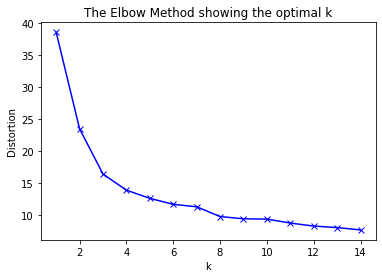

In [24]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [25]:
kclusters = 4 #kcluster = number of clusters
# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(X)
    
#insert labels and separately stored datas
clustered_data = X.copy()
clustered_data.insert(0, "Neighborhood", neighborhoods)
clustered_data.insert(1, "Neighborhood Latitude", lats)
clustered_data.insert(2, "Neighborhood Longitude", lngs)
clustered_data.insert(3, f'Cluster Labels', kmeanModel.labels_)
clustered_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Parkwoods,43.753259,-79.329656,2,0,1,0,1,0,4,9,4,4,4
1,Victoria Village,43.725882,-79.315572,0,2,1,0,5,0,4,19,7,18,4
2,"Regent Park, Harbourfront",43.654260,-79.360636,1,49,8,3,49,29,44,46,38,41,33
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,4,1,0,13,2,6,27,0,34,1
4,Ontario Provincial Government,43.662301,-79.389494,1,45,48,0,50,42,43,49,49,46,33


# Visualize results

## Geospatial map

In [26]:
# create map of New York using latitude and longitude values
map_fig = folium.Map(location=[43.6534817, -79.3839347], zoom_start=10)

# set color scheme for the clusters
kclusters = len(clustered_data["Cluster Labels"].unique())
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_data["Neighborhood Latitude"], clustered_data["Neighborhood Longitude"], clustered_data["Neighborhood"], clustered_data['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=f"<i>{str(poi)}, <b> Cluster {str(cluster)}</b></i>",
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_fig)
    
map_fig        

## List top categories for each cluster

In [27]:
def get_top_n_categories(df, n):
    output = df[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"]].copy()
    df = df.drop(["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude", "Cluster Labels"], axis=1)
    
    #append columns that contain n largest categories
    while n > 0:
        means = df.loc[-1]
        n_largest_category = means[means == max(means)].index[0]
        
        #add n_largest_category to output df
        output[n_largest_category] = df[n_largest_category]
        
        #remove n_largest_category from original df
        df = df.drop(n_largest_category, axis=1)
        
        n-=1
   
    return output

In [28]:
clusters_top_categories = my_dictionary()

for clusterlabel in range(kclusters):
    cluster_data = clustered_data[clustered_data["Cluster Labels"] == clusterlabel].copy()
    cluster_data.loc[-1] = cluster_data.mean(axis=0)
    
    clusters_top_categories.add(f"Cluster {clusterlabel}", get_top_n_categories(cluster_data, 5))

In [29]:
def get_piedata(data, catColDict):
    data = data.iloc[:, 3:]
    
    #get values
    values = data.loc[-1]
    
    #get labels
    labels = data.columns
    n_max = sum(values)
    labels_with_perc = [label + f", {np.round(data[label].loc[-1]/n_max*100, 2)}%" for label in data.columns]
    
    #get color
    label_colors = [catColDict[category] for category in labels]
    
    return values, labels_with_perc, label_colors

In [30]:
def visualize_cluster(data, cluster, catColDict):
    values, labels, label_colors = get_piedata(clusters_top_categories[cluster], catColDict)
    
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.pie(values, labels = labels, colors = label_colors)
    ax.set_title(f"Percentage of venues in Neighborhoods of {cluster}", size=17)
    plt.show()
    return

In [31]:
#create colors dictionary
categories = list(clustered_data.columns[4:])
colors_array = cm.rainbow(np.linspace(0, 1, len(categories)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
categories_color_dict = {category: color for (category, color) in zip(categories, rainbow)}

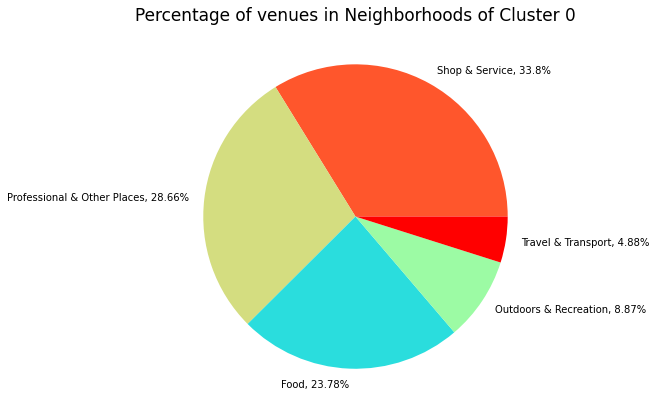

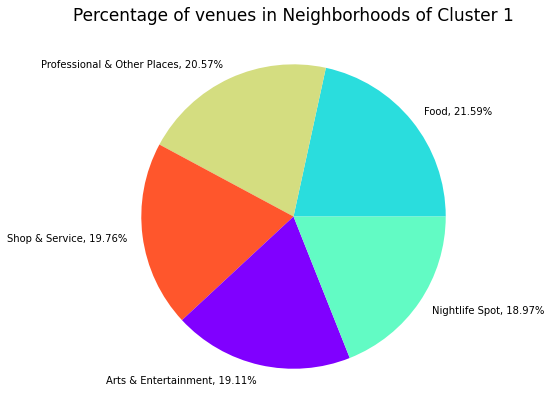

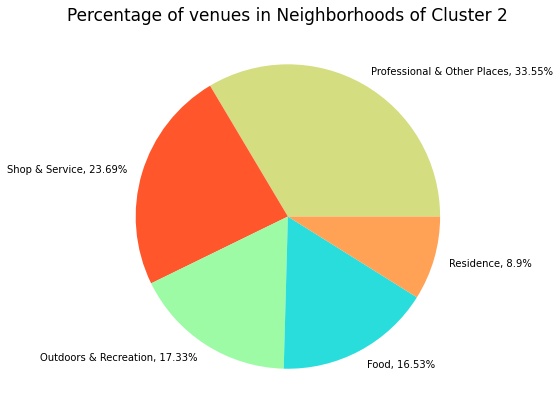

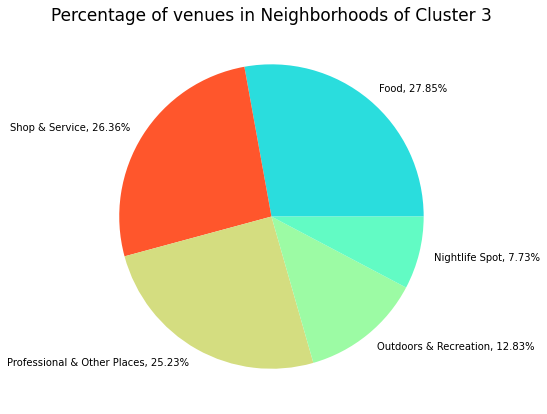

In [34]:
for clusterNr in range(clustered_data["Cluster Labels"].min(), clustered_data["Cluster Labels"].max() + 1):
    visualize_cluster(clusters_top_categories, f"Cluster {clusterNr}", categories_color_dict)

# Final thoughts

During this project we examined the city of Toronto. Therefore, we scraped a lot of data, transformed it and create beautiful output from it. To fullfill the task introduced in the introduction, you have to do the following steps:
1. Look for the cluster your current neighborhood is located in or inspect the clusters to find out the cluster that matches your needs the most.
2. Search for neighborhoods of the same cluster in your target location.
3. Move to the new neighborhood.